Goal: Predicting the outcome of games


Step 1: Finding key variables

Dean Oliver's - FG%, TO, OR, FTA

the player should:

Shoot a high field goal percentage or help teammates shoot a high percentage through assists and playmaking.
Avoid turnovers.
Get offensive rebounds.
Draw fouls.
At the defensive end, the player should:

Make offensive players take low percentage shots.
Cause turnovers.
Box out and prevent offensive rebounds.
Avoid fouls.

Step 2: Create a model that helps us predict a game.

Create a metric that gives us how a player impacts winning based on Dean Oliver.

Given pregame lineups, determine who will win a game.

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statistics import median

%matplotlib inline

In [2]:
from datetime import datetime, timedelta, date
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

In [3]:
teamBoxScore = pd.read_csv("nba-enhanced-stats/2012-18_teamBoxScore.csv")
teamResult = teamBoxScore['teamRslt']
teamBoxScore.head()

,gmDate,gmTime,seasTyp,offLNm1,offFNm1,offLNm2,offFNm2,offLNm3,offFNm3,teamAbbr,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,2012-10-30,19:00,Regular,Brothers,Tony,Smith,Michael,Workman,Haywoode,WAS,...,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
1,2012-10-30,19:00,Regular,Brothers,Tony,Smith,Michael,Workman,Haywoode,CLE,...,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,88.9409,88.9409
2,2012-10-30,20:00,Regular,McCutchen,Monty,Wright,Sean,Fitzgerald,Kane,BOS,...,80.8333,126.3381,112.6515,13.6866,0.5244,19.8287,3.1250,100.0000,94.9832,94.9832
3,2012-10-30,20:00,Regular,McCutchen,Monty,Wright,Sean,Fitzgerald,Kane,MIA,...,62.7083,112.6515,126.3381,-13.6866,0.4643,18.8501,1.5000,25.0000,94.9832,94.9832
4,2012-10-30,22:30,Regular,Foster,Scott,Zielinski,Gary,Dalen,Eric,DAL,...,58.6458,99.3678,108.1034,-8.7356,0.5000,18.6567,1.7143,42.8571,91.5790,91.5790


In [4]:
playerBoxScore = pd.read_csv("nba-enhanced-stats/2012-18_playerBoxScore.csv")
playerBoxScore.head()

,gmDate,gmTime,seasTyp,playLNm,playFNm,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,...,playFT%,playORB,playDRB,playTRB,opptAbbr,opptConf,opptDiv,opptLoc,opptRslt,opptDayOff
0,2012-10-30,19:00,Regular,Price,A.J.,WAS,East,Southeast,Away,Loss,...,1.0,1,1,2,CLE,East,Central,Home,Win,0
1,2012-10-30,19:00,Regular,Ariza,Trevor,WAS,East,Southeast,Away,Loss,...,0.5,1,2,3,CLE,East,Central,Home,Win,0
2,2012-10-30,19:00,Regular,Okafor,Emeka,WAS,East,Southeast,Away,Loss,...,0.5,5,2,7,CLE,East,Central,Home,Win,0
3,2012-10-30,19:00,Regular,Beal,Bradley,WAS,East,Southeast,Away,Loss,...,1.0,0,3,3,CLE,East,Central,Home,Win,0
4,2012-10-30,19:00,Regular,Booker,Trevor,WAS,East,Southeast,Away,Loss,...,0.0,1,0,1,CLE,East,Central,Home,Win,0


In [5]:
standings = pd.read_csv("nba-enhanced-stats/2012-18_standings.csv")
standings.head()

,stDate,teamAbbr,rank,rankOrd,gameWon,gameLost,stk,stkType,stkTot,gameBack,...,rel%Indx,mov,srs,pw%,pyth%13.91,wpyth13.91,lpyth13.91,pyth%16.5,wpyth16.5,lpyth16.5
0,2012-10-30,ATL,3,3rd,0,0,-,-,0,0.5,...,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000
1,2012-10-30,BKN,3,3rd,0,0,-,-,0,0.5,...,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000
2,2012-10-30,BOS,14,14th,0,1,L1,loss,1,1.0,...,0.0,-13.0,-13.0,0.072,0.1687,13.8334,68.1666,0.131,10.742,71.258
3,2012-10-30,CHA,3,3rd,0,0,-,-,0,0.5,...,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000
4,2012-10-30,CHI,3,3rd,0,0,-,-,0,0.5,...,0.0,0.0,0.0,0.500,0.0000,0.0000,82.0000,0.000,0.000,82.000


In [6]:
# Set some variables to hold test, dev, and training data.
test_data, test_labels = teamBoxScore[12500:], teamResult[12500:]
dev_data, dev_labels = teamBoxScore[11000:12500], teamResult[11000:12500]
train_data, train_labels = teamBoxScore[:11000], teamResult[:11000]
mini_train_data, mini_train_labels = teamBoxScore[:1000], teamResult[:1000]

In [7]:
def x_days_before(s, x):
    date = datetime.strptime(s, "%Y-%m-%d")
    modified_date = date - timedelta(days=x)
    return modified_date

In [26]:
#Naive Model - predicts team with better record.. if teams are tied, then predicts home team

#for every game in dev_data:
#  if there exists day_before record of both teams:
#    set record1, record2 to be the day_before_record of teams
#  if record1 != record2:
#    predict better record
#  else:
#    predict home team


temp_standings = standings[['stDate', 'teamAbbr', 'gameWon', 'gameLost']]
correct = 0
wrong = 0

for row in teamBoxScore.iterrows():
    date = row[1]['gmDate'] #30
    day_before = x_days_before(date, 1)
    first_date = datetime.strptime(temp_standings.iloc[0]['stDate'], "%Y-%m-%d")
    
    if day_before > first_date:
        for i in range(30):
            temp_standings = temp_standings.drop(temp_standings.index[0])
    
    first_date = datetime.strptime(temp_standings.iloc[0]['stDate'], "%Y-%m-%d")
    
    team1 = row[1]['teamAbbr']
    team2 = row[1]['opptAbbr']

    if day_before == first_date:
        dayb4 = datetime.strftime(day_before, "%Y-%m-%d")
        dayb4_df = temp_standings.loc[temp_standings['stDate'] == dayb4]
        
        team1Rec = dayb4_df.loc[dayb4_df['teamAbbr'] == team1]
        team2Rec = dayb4_df.loc[dayb4_df['teamAbbr'] == team2]
        
        team1Over500 = team1Rec.iloc[0]['gameWon'] - team1Rec.iloc[0]['gameLost']
        team2Over500 = team2Rec.iloc[0]['gameWon'] - team2Rec.iloc[0]['gameLost']
        
        if team1Over500 > team2Over500:
            prediction = 'Win'
        elif team1Over500 < team2Over500:
            prediction = 'Loss'
        elif row[1]['teamLoc'] == 'Home':
            prediction = 'Win'
        else:
            prediction = 'Loss'
    else:
        if row[1]['teamLoc'] == 'Home':
            prediction = 'Win'
        else:
            prediction = 'Loss'
    if prediction == row[1]['teamRslt']:
        correct += 1
    else:
        wrong += 1

print(correct)
print(wrong)

9583
5175


Naive model has an accuracy of ~64.9%. We should aim for our model to get above this mark.

In [9]:
#Fill a list with names of officials.
off_set = set()

for row in teamBoxScore.iterrows():
    off1 = str(row[1]['offFNm1'] + ' ' + row[1]['offLNm1'])
    off_set.add(off1)
    
    off2 = str(row[1]['offFNm2']) + ' ' + str(row[1]['offLNm2'])
    off_set.add(off2)
    
    off3 = str(row[1]['offFNm3']) + ' ' + str(row[1]['offLNm3'])
    off_set.add(off3)
    
off_list = list(sorted(off_set))
off_len = len(off_list)

In [10]:
# Create a matrix of which officials officiated which games
# Each game indicates a unique game
# 1 indicates a game an official worked in
off_matrix = np.empty((int(len(teamBoxScore.index) / 2), off_len))

count = -1
for row in teamBoxScore.iterrows():
    count += 1
    
    #managing repeating games
    if count % 2 == 1:
        continue

    off1 = str(row[1]['offFNm1'] + ' ' + row[1]['offLNm1'])
    off1_index = off_list.index(off1)

    off2 = str(row[1]['offFNm2']) + ' ' + str(row[1]['offLNm2'])
    off2_index = off_list.index(off2)
    
    off3 = str(row[1]['offFNm3']) + ' ' + str(row[1]['offLNm3'])
    off3_index = off_list.index(off3)
    
    off_matrix[count // 2][off1_index] = 1
    off_matrix[count // 2][off2_index] = 1
    off_matrix[count // 2][off3_index] = 1
    
off_df = pd.DataFrame(off_matrix, columns = off_list)
off_df.head()

,Aaron Smith,Ben Taylor,Bennett Salvatore,Bennie Adams,Bill Kennedy,Bill Spooner,Brandon Adair,Brenda Pantoja,Brent Barnaky,Brett Nansel,...,Steven Anderson,Tom Washington,Tony Brothers,Tony Brown,Tre Maddox,Tyler Ford,Violet Palmer,Vladimir Voyard-Tadal,Zach Zarba,nan nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#Fill a list with names of players.
player_set = set()

for row in playerBoxScore.iterrows():
    player = str(row[1]['playFNm'] + ' ' + row[1]['playLNm'])
    player_set.add(player)
    
temp_list = list(sorted(player_set))

player_list = []
for player in temp_list:
    player_list.append(player)
    player_list.append(player + " - Away")
    
player_len = len(player_list)

In [12]:
# Create a matrix of which players played in which games
# 1 indicates a player playing in the game

player_matrix = np.empty((int(len(teamBoxScore.index) / 2), player_len))

count = -1
current_team = 'wow I really enjoyed this course Amit'
for row in playerBoxScore.iterrows():
    if row[1]['teamAbbr'] != current_team:
        current_team = row[1]['teamAbbr']
        count += 1
    player = str(row[1]['playFNm'] + ' ' + row[1]['playLNm'])
    player_index = player_list.index(player)
    
    if row[1]['teamLoc'] == 'Home':
        player_matrix[count // 2][player_index] = 1
    else:
        player_matrix[count // 2][player_index + 1] = 1
    
player_df = pd.DataFrame(player_matrix, columns = player_list)
player_df.head()

,A.J. Price,A.J. Price - Away,Aaron Brooks,Aaron Brooks - Away,Aaron Gordon,Aaron Gordon - Away,Aaron Gray,Aaron Gray - Away,Aaron Hammons,Aaron Hammons - Away,...,Zach Randolph,Zach Randolph - Away,Zachary LaVine,Zachary LaVine - Away,Zaza Pachulia,Zaza Pachulia - Away,Zhou Qi,Zhou Qi - Away,Zoran Dragić,Zoran Dragić - Away
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Find EFG% for each team in the season leading up to a game
# Do this by tracking their FGM, 3PM, and FGA

#Creating a list of names
team_names_set = set()
for row in teamBoxScore.iterrows():
    team_names_set.add(row[1]['teamAbbr'])
    team_names_set.add(row[1]['opptAbbr'])
    
    if len(team_names_set) == 30:
        break
team_names_list = list(sorted(team_names_set))

#matrix keeping track of efg before every game
efg_matrix = np.zeros((len(teamBoxScore.index) // 2, 10))
efg_columns_list = ['teamEFG%', 'opptEFG%','teamEFG%A', 'opptEFG%A','teamPF', 'opptPF',
                    'teamTO', 'opptTO', 'teamOREB', 'opptOREB']

#matrix calculating each team's cumulative EFG%
team_stats_matrix = np.zeros((30, 11)) ###(ADJUSTABLE)

prev_date = datetime.strptime('2012-10-29', "%Y-%m-%d")
count = -1
for row in teamBoxScore.iterrows():
    count += 1
    
    #managing repititons
    if row[1]['teamLoc'] == 'Away':
        continue
    
    #finding index of the two teams playing
    team = row[1]['teamAbbr']
    oppt = row[1]['opptAbbr']
    team_index = team_names_list.index(team)
    oppt_index = team_names_list.index(oppt)
    
    #helper function that accesses the team_stats_matrix
    team_row = team_stats_matrix[team_index]
    oppt_row = team_stats_matrix[oppt_index]
    
    #updating efg_matrix
    efg_matrix[count // 2][0] = team_row[3]
    efg_matrix[count // 2][2] = team_row[7]
    efg_matrix[count // 2][4] = team_row[8]
    efg_matrix[count // 2][6] = team_row[9]
    efg_matrix[count // 2][8] = team_row[10]
    efg_matrix[count // 2][1] = oppt_row[3]
    efg_matrix[count // 2][3] = oppt_row[7]
    efg_matrix[count // 2][5] = oppt_row[8]
    efg_matrix[count // 2][7] = oppt_row[9]
    efg_matrix[count // 2][9] = oppt_row[10]

    #updating team_stats_matrix for this game
    team_row[0] += row[1]['teamFGM']
    team_row[1] += row[1]['team3PM']
    team_row[2] += row[1]['teamFGA']
    team_row[3] = (team_row[0] + 0.5 * (team_row[1])) / team_row[2] #teamEFG%
    team_row[4] += row[1]['opptFGM']
    team_row[5] += row[1]['oppt3PM']
    team_row[6] += row[1]['opptFGA']
    team_row[7] = (team_row[4] + 0.5 * (team_row[5])) / team_row[6] #teamEFG%A
    team_row[8] += row[1]['teamPF'] #teamPF
    team_row[9] += row[1]['teamTO'] #teamTO
    team_row[10] += row[1]['teamORB'] #teamOREB
    
    oppt_row[0] += row[1]['opptFGM']
    oppt_row[1] += row[1]['oppt3PM']
    oppt_row[2] += row[1]['opptFGA']
    oppt_row[3] = (oppt_row[0] + 0.5 * (oppt_row[1])) / oppt_row[2] #opptEFG%
    oppt_row[4] += row[1]['teamFGM']
    oppt_row[5] += row[1]['team3PM']
    oppt_row[6] += row[1]['teamFGA']
    oppt_row[7] = (oppt_row[4] + 0.5 * (oppt_row[5])) / oppt_row[6] #opptEFG%A
    oppt_row[8] += row[1]['opptPF'] #opptPF
    oppt_row[9] += row[1]['opptTO'] #opptTO
    oppt_row[10] += row[1]['opptORB'] #opptORB
    
    current_date = datetime.strptime(row[1]['gmDate'], "%Y-%m-%d")
    if (current_date - prev_date).days > 90:
        team_stats_matrix = np.zeros((30, 11)) ###(ADJUSTABLE)

    prev_date = current_date

column_names = ['FGM', '3PM', 'FGA', 'EFG%', 'FGMA', '3PMA', 'FGAA', 'EFG%A', 'PF', 'TO', 'ORB']
totals_df = pd.DataFrame(team_stats_matrix, index = team_names_list, columns = column_names)
#loading efg_matrix data onto a dataframe

stats_df = pd.DataFrame(efg_matrix, columns = efg_columns_list)
stats_df.tail()

,teamEFG%,opptEFG%,teamEFG%A,opptEFG%A,teamPF,opptPF,teamTO,opptTO,teamOREB,opptOREB
7374,0.512067,0.526666,0.526119,0.522674,1552.0,1721.0,1178.0,1188.0,717.0,804.0
7375,0.534821,0.532306,0.492390,0.527453,1794.0,1735.0,1344.0,1113.0,876.0,680.0
7376,0.527256,0.516550,0.519144,0.514405,1621.0,1713.0,1192.0,1279.0,824.0,866.0
7377,0.511004,0.528627,0.504315,0.506404,1577.0,1589.0,1101.0,1194.0,828.0,725.0
7378,0.502292,0.551899,0.543446,0.521482,1625.0,1573.0,1116.0,1131.0,771.0,731.0


In [33]:
# Dataframe comparing the two teams records
# This will just be one column titled "Games Ahead" describing how many games ahead the home team is from the away team
# EG: Home: 26-13 Away: 22-16 
#     Games Ahead = ((26-13) - (22 - 16)) / 2 = 3.5

# pull standings data: we want date, teamAbbr, wins, losses
# for each game played,
# look at standings for home team and away team for the PREVIOUS DAY
# calculate Games Ahead
# put into new dataframe
# count = 0
games_ahead_list = []

temp_standings = standings[['stDate', 'teamAbbr', 'gameWon', 'gameLost']]
for row in teamBoxScore.iterrows():
    if row[1]['teamLoc'] == 'Away':
        continue
    else:
        date = row[1]['gmDate']
        day_before = x_days_before(date, 1)
        first_date = datetime.strptime(temp_standings.iloc[0]['stDate'], "%Y-%m-%d")

        if day_before > first_date:
            for i in range(30):
                temp_standings = temp_standings.drop(temp_standings.index[0])
                
        first_date = datetime.strptime(temp_standings.iloc[0]['stDate'], "%Y-%m-%d")

        team1 = row[1]['teamAbbr']
        team2 = row[1]['opptAbbr']
        
        games_ahead = 0
        
        if day_before == first_date:
            dayb4 = datetime.strftime(day_before, "%Y-%m-%d")
            dayb4_df = temp_standings.loc[temp_standings['stDate'] == dayb4]

            team1Rec = dayb4_df.loc[dayb4_df['teamAbbr'] == team1]
            team2Rec = dayb4_df.loc[dayb4_df['teamAbbr'] == team2]

            team1Over500 = team1Rec.iloc[0]['gameWon'] - team1Rec.iloc[0]['gameLost']
            team2Over500 = team2Rec.iloc[0]['gameWon'] - team2Rec.iloc[0]['gameLost']
            
            games_ahead = (team1Over500 - team2Over500) / 2
        
        games_ahead_list.append(games_ahead)

7379


In [35]:
games_ahead_df = pd.DataFrame(np.array(games_ahead_list), columns = ['gamesAhead'])
games_ahead_df.tail()

,gamesAhead
7374,-19.0
7375,7.0
7376,8.0
7377,0.0
7378,-39.0


In [36]:
#Combining our dataframes
data_df = pd.concat([off_df, player_df, stats_df, games_ahead_df], axis=1, sort=False)
data_matrix = np.matrix(data_df)

results_df = teamBoxScore.loc[teamBoxScore['teamLoc'] == 'Home']['teamRslt']
results_array = np.array(results_df)

test_data1, test_labels1 = data_matrix[6149:], results_array[6149:]
dev_data1, dev_labels1 = data_matrix[4919:6149], results_array[4919:6149]
train_data1, train_labels1 = data_matrix[:4919], results_array[:4919]
mini_train_data1, mini_train_labels1 = data_matrix[:1000], results_array[:1000]

In [37]:
# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

C:\Users\georg\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6138944453802165


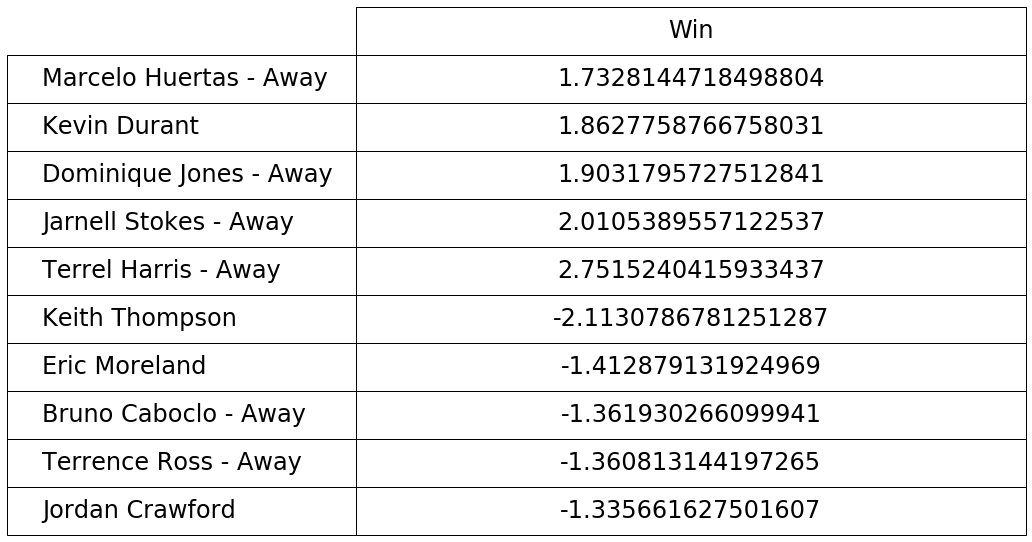

In [40]:
logRegression = LogisticRegression(penalty = 'l1')
logRegression.fit(train_data1, train_labels1)
predictions = logRegression.predict(dev_data1)


score = metrics.f1_score(dev_labels1, predictions, average = "weighted")
print(score)

#Finding most important features in our model and their respective indices
#They get put into the lists, important_features and important_indices
label_weights = logRegression.coef_
features = list(data_df.columns)
important_features = []
important_indices = []

largest_weights = sorted(label_weights[0])[-5:]
largest_weights_indices = [list(label_weights[0]).index(largest_weights[0]), 
                          list(label_weights[0]).index(largest_weights[1]),
                         list(label_weights[0]).index(largest_weights[2]),
                          list(label_weights[0]).index(largest_weights[3]),
                          list(label_weights[0]).index(largest_weights[4])]

smallest_weights = sorted(label_weights[0])[:5]
smallest_weights_indices = [list(label_weights[0]).index(smallest_weights[0]), 
                          list(label_weights[0]).index(smallest_weights[1]),
                         list(label_weights[0]).index(smallest_weights[2]),
                          list(label_weights[0]).index(smallest_weights[3]),
                          list(label_weights[0]).index(smallest_weights[4])]
for i in range(5):
    important_features.append(features[largest_weights_indices[i]])
    important_indices.append(largest_weights_indices[i])
for i in range(5):
    important_features.append(features[smallest_weights_indices[i]])
    important_indices.append(smallest_weights_indices[i])

#Create a nested list of size [20][4] to hold all of the label's weights for
#our important features.
cell_text = []
for index in range(10):
    row_text = []
    row_text.append(label_weights[0][important_indices[index]])
    cell_text.append(row_text)

#Create the table
the_table = plt.table(cellText = cell_text,
                      rowLabels = important_features, 
                      colLabels = ['Win'],
                      loc = 'center',
                     cellLoc = 'center')
the_table.set_fontsize(24)
the_table.scale(2, 4)

# Removing ticks and spines enables you to get the figure only with table
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)

In [41]:
multiNB = MultinomialNB()
multiNB.fit(train_data1, train_labels1)

predictions = multiNB.predict(dev_data1)
score = metrics.f1_score(dev_labels1, predictions, average = "weighted")
score

ValueError: Input X must be non-negative

In [ ]:
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(train_data1, train_labels1)
    predictions = knn.predict(dev_data1)

    score = metrics.f1_score(dev_labels1, predictions, average = "weighted")
    print(score)

0.5055511361952864
0.46916806648275133
0.5408830178620376


In [ ]:
len(stats_df.index)